In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Load data

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

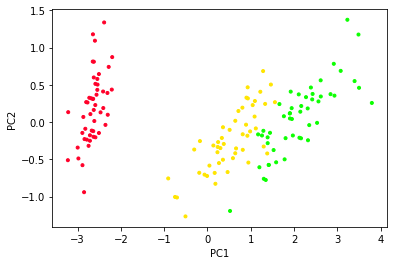

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


# Get VB params 

In [6]:
k_approx = 30

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1459.0115663552124

## Initialize 

In [10]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6580.095037059639


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

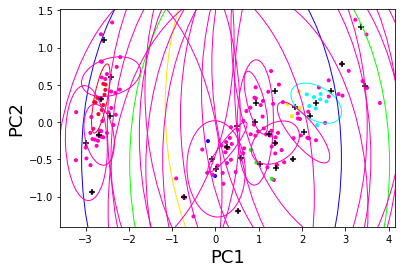

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [13]:
vb_opt_dict, e_z_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 266
stick_time: 1.559sec
cluster_time: 0.151sec
e_z_time: 0.403sec
**TOTAL time: 4.761sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [15]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights)


In [16]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [17]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.0111sec


In [18]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.0614sec


In [19]:
# if its impossible, don't run the hessian
run_hessian = True

In [20]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 14.3sec


In [21]:
t0 = time.time()
hvp = obj_fun_hvp(vb_opt, prior_params_free, vb_opt)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.126sec


In [22]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [23]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 4.3sec


# Solver times

In [24]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.00149sec


In [25]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 13.0sec


In [26]:
preconditioner = preconditioner_lib.get_gmm_preconditioner(vb_opt, vb_params_paragami)

In [27]:
cg_solver_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 6.98sec


# Lets look at the CG solver in more detail 

### Check out eigenvalues

In [35]:
hess_ev = np.linalg.eigvals(hess)

In [36]:
precond_sqrt = osp.linalg.sqrtm(preconditioner.toarray())
np.abs(precond_sqrt - precond_sqrt.transpose()).max()

3.567538391042636e-14

In [37]:
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))

In [38]:
precon_hess_ev = np.linalg.eigvals(precond_hess)

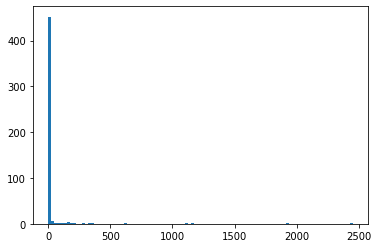

In [39]:
plt.hist(hess_ev - hess_ev.min(), bins = 100);

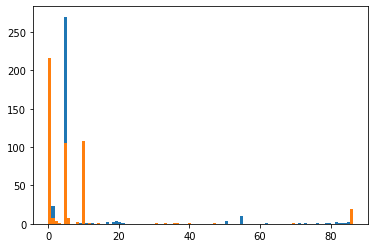

In [40]:
foo = precon_hess_ev - precon_hess_ev.min()
bins = plt.hist(foo, bins = 100);
plt.hist((hess_ev - hess_ev.min()).clip(max = foo.max()), bins = bins[1]);

In [41]:
dim = len(vb_opt)
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
linop = osp.sparse.linalg.LinearOperator((dim, dim), mat_times_vec)

b = cross_hess[:, 0]

### Check out optimization path

In [42]:
class CGCallback(): 
    def __init__(self, mat_times_vec, b): 
        self.mat_times_vec = mat_times_vec
        self.b = b
        
        self.residuals = []
        
    def record_residuals(self, x): 
#         e_z = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
#                                        vb_params_paragami.fold(x, free = True), 
#                                        gh_loc, gh_weights)
        
#         e_num_clust = cluster_lib.get_e_num_clusters_from_ez(e_z)
        
#         self.residuals.append(e_num_clust)
        
#         self.residuals.append(np.linalg.norm(b - self.mat_times_vec(x)))

        self.residuals.append(np.linalg.norm(-x - dinput_dhyper[:, 0]))
        
    def return_path(self): 
        return np.array(self.residuals)

In [43]:
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
b = cross_hess[:, 0]
cg_callback = CGCallback(mat_times_vec, b)

x0 = preconditioner.dot(b)

In [44]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path1 = cg_callback.return_path()

solver time: 9.4sec


In [45]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':preconditioner, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path2 = cg_callback.return_path()

solver time: 4.5sec


Text(0, 0.5, 'log10 residual')

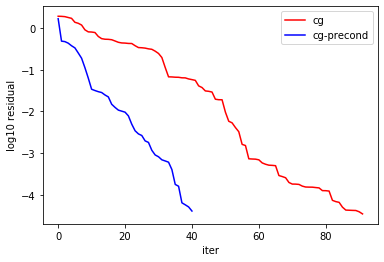

In [46]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond')
plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Try nystrom

In [47]:
def taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter):
    
    t_power = deepcopy(v)
    x_inv_v = deepcopy(v)
    
    for i in range(max_iter): 
        t_power = t_power - mat_vec(t_power) / (max_eval + 1)
        x_inv_v += t_power
    
    return x_inv_v / (max_eval + 1)

In [48]:
# a quick test 
dim = 3
_a = np.random.randn(dim, dim)
a = np.dot(_a, _a.transpose())

mat_vec = lambda x: np.dot(a, x)

max_eval = np.linalg.eigvals(a).max()

v = np.random.randn(dim)

foo = taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter = 1000)

true = np.linalg.solve(a, v)

print(foo / true)

[0.99998116 0.99998158 0.99998168]


In [49]:
def get_nystrom_woodbury_approx(A, indx): 
    C = A[:, indx]
    W_inv = np.linalg.inv(A[indx][:, indx])
    
    inv_term = np.linalg.inv(np.eye(C.shape[1]) + np.dot(W_inv, np.dot(C.transpose(), C)))
    
    woodb_inv = np.eye(C.shape[0]) - np.dot(np.dot(C, inv_term), np.dot(W_inv, C.transpose()))
    
    return woodb_inv, C, W_inv

In [50]:
# another quick test 
a = np.random.randn(3, 3)
A = np.eye(3) + np.dot(a, a.transpose())

woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx = np.array([0, 1]))

A_tilde = np.dot(np.dot(C, W_inv), C.transpose())

np.abs(np.linalg.inv(np.eye(3) + A_tilde) - woodb_inv).max()

2.220446049250313e-16

In [51]:
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                       vb_params_paragami.fold(vb_opt, free = True), 
                                       gh_loc, gh_weights)

In [88]:
k_large = 3
which_k = np.argsort(e_z_opt.mean(0))[0:k_large]

In [89]:
which_k

array([28, 27, 26])

In [90]:
bool_dict = vb_params_paragami.empty_bool(False)
bool_dict['cluster_params']['centroids'][:, which_k] = True
bool_dict['cluster_params']['cluster_info'][which_k] = True

_which_k = which_k[which_k != (k_approx - 1)]
bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
bool_dict['stick_params']['stick_propn_info'][_which_k] = True

In [91]:
indx = vb_params_paragami.flat_indices(bool_dict, free = True)

In [92]:
len(indx)

48

In [93]:
lambda_max = np.max(np.linalg.eigvals(hess))

A = hess / lambda_max - np.eye(hess.shape[0])

In [94]:
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx)
nystrom_precond = woodb_inv/lambda_max

In [95]:
precond_sqrt = osp.linalg.sqrtm(preconditioner.toarray())
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

(86.68719394590939+0j)
(226.51603721982949+0j)


In [96]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

(1.0000000000002207-5.527948772018378e-19j)
(7653.885932252715+1.0581759865362478e-11j)


In [156]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path3 = cg_callback.return_path()

solver time: 13.9sec


Text(0, 0.5, 'log10 residual')

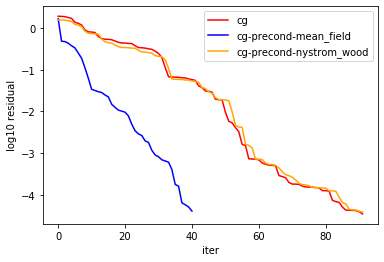

In [157]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

In [158]:
hess.shape

(478, 478)